<a href="https://colab.research.google.com/github/wildflowersbloom/data_understanding/blob/main/Fonts_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Open fonts/typeface match

Author: Barbara Casillas

Task: match fonts/typeface from text in photo input to (open source) fonts.

There is existing propietary font-identification software (e.g. Match Font from Adobe Photoshop, Font Finder, What the Font, Find my Font, Matcherator). My aim here is is learn how do transfer learning (re  is to contribute simpler code, contained in a single notebook, that can be customized for font-identification projects. Another, more distant goal, is to match fonts to a growing library of  open fonts, such as the great quality fonts compiled in the [Open Source Font Library](https://fontlibrary.org/en) and in the [Open Foundry
](https://open-foundry.com/fonts).

### Inspiring projects
1. [Fontjoy](https://fontjoy.com/) approaches the problem of font pairing (selecting fonts that have some contrast, but go well together) using a neural net. They embed images of fonts into vectors which encode information about the font. The pairing score rewards both similarities and disimilarities (i.e. positive and negative cosine similarity) to get fonts that are very similar in some respects but very different in other respects. The data comes frome [Google  Fonts](https://github.com/google/fonts)

1. [Stefann](https://www.kaggle.com/code/prasunroy/starter-1-font-generation-stefann-cvpr-2020) in this paper, the authors propose a method to modify text (a whole word or characters) present in a scene. A font adaptive neural network (FANnet) is trained to achieve consistency between the source font and the target to replace it. A second neural network is used to colorize the text. The data ultimatley comes frome [Google  Fonts](https://github.com/google/fonts) *Use FanNet ready for training dataset*

1. Clova AI (Naver/Line corps, Corea) proposed a framework for Scene text detection and recognition that has four modules or stages: Transformation (TPS,flatten geometry), Feature extraction (ResNet,font, color, size, background, dropped), Sequence modeling (BiLSTMs, what is the next character), and Prediction (Attn,what is the next word).[Towardsdatascience blog entry](https://towardsdatascience.com/pytorch-scene-text-detection-and-recognition-by-craft-and-a-four-stage-network-ec814d39db05).  *Take the transformation and feature extraction modules, as a head to our classification task.*

1. A similar problem of font recognition was posed as a kaggle [competition](https://www.kaggle.com/competitions/font-recognition/overview) one year ago.  Best score 95%. Competition closed, no acccess to data or code.

### Datasets
1. [Google Fonts](https://github.com/google/fonts)
1. [FanNet](https://www.kaggle.com/code/prasunroy/starter-1-font-generation-stefann-cvpr-2020) [git dataset](https://github.com/prasunroy/stefann#1-downloading-datasets)

### Steps
1. Use Craft to recognize characters.
1. Transformation module: Thin-Plate Spline (TPS) transformation, normalize the input text into a rectangular shape.
1. Feature Extraction module: Font. (ResNet)
1. Classification into fonts. 




### Try
Follow this [tutorial](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html) for general transfer learning with pytorch




In [32]:
#import copy
#import math
import matplotlib.pyplot
import numpy
import os
import requests
import time
import tqdm
import zipfile

import torch
import torchvision
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)


PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111


In [33]:
#device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
#!nvidia-smi

Follow this [tutorial](https://towardsdatascience.com/pytorch-scene-text-detection-and-recognition-by-craft-and-a-four-stage-network-ec814d39db05) to transform images and extract features.

In [34]:
# Clone CRAFT
#!git clone https://github.com/clovaai/CRAFT-pytorch.git

In [35]:
#Install CRAFT directly as an alternative
!pip install craft-text-detector

In [36]:
# Advanced mode
from craft_text_detector import (
    read_image,
    load_craftnet_model,
    load_refinenet_model,
    get_prediction,
    export_detected_regions,
    export_extra_results,
    empty_cuda_cache
)

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
# set image path and export folder directory
image = '/content/drive/MyDrive/ASIGMO_DS/00_75_83.jpg' # can be filepath, PIL image or numpy array
output_dir = 'outputs/'

In [39]:
# read image
image = read_image(image)

<function matplotlib.pyplot.show>

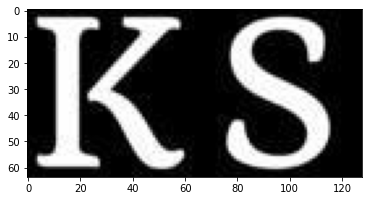

In [40]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.show

In [41]:
# load models
refine_net = load_refinenet_model(cuda=False)
craft_net = load_craftnet_model(cuda=False) #True

In [42]:
# perform prediction
prediction_result = get_prediction(
    image=image,
    craft_net=craft_net,
    #refine_net=refine_net, #16s with/ 11s without
    text_threshold=0.7,
    link_threshold=0.4,
    low_text=0.4,
    cuda=False,
    long_size=1280
)

In [43]:
# export detected text regions
exported_file_paths = export_detected_regions(
    image=image,
    regions=prediction_result["boxes"],
    output_dir=output_dir,
    rectify=True
)

In [44]:
# export heatmap, detection points, box visualization
export_extra_results(
    image=image,
    regions=prediction_result["boxes"],
    heatmaps=prediction_result["heatmaps"],
    output_dir=output_dir
)

# unload models from gpu
#empty_cuda_cache()

<function matplotlib.pyplot.show>

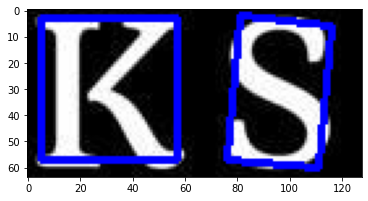

In [45]:
# show character detection
plt.imshow(image)
plt.show

In [46]:
# takes image filename, returns character bounding boxes
def craft_wrapper(image_filename, refine_net,craft_net):
  image = read_image(image_filename)
  prediction_result = get_prediction(
    image=image,
    craft_net=craft_net,
    #refine_net=refine_net, #16s with/ 11 without
    text_threshold=0.7,
    link_threshold=0.4,
    low_text=0.4,
    cuda=False,
    long_size=1280)
  return prediction_result['boxes']


In [47]:
# test wrapper function
%%time
image = '/content/drive/MyDrive/ASIGMO_DS/00_75_83.jpg' 
craft_wrapper(image,refine_net,craft_net)

CPU times: user 11.1 s, sys: 103 ms, total: 11.2 s
Wall time: 11.2 s


### Transfer learning
From deep-text recognition get trained layers for image transformation (geometric flatten) and font recognition, to use the output for font classification
https://github.com/clovaai/deep-text-recognition-benchmark.git

In [48]:
# Clone deep-text recognition
!git clone https://github.com/clovaai/deep-text-recognition-benchmark.git

fatal: destination path 'deep-text-recognition-benchmark' already exists and is not an empty directory.


In [49]:
# Libraries
import torch.nn as nn
import torch

# Load feature_extraction and transformation modules from my computer
#from google.colab import files
#files.upload()

# Load feature_extraction and transformation modules from drive (cloned repo)
import sys
sys.path.insert(0,'/content/deep-text-recognition-benchmark')

# Import methods from modules
from modules.feature_extraction import ResNet_FeatureExtractor
from modules.transformation import TPS_SpatialTransformerNetwork
from dataset import RawDataset, AlignCollate

In [50]:
# Define model class
class Model(nn.Module):
    def __init__(self, opt):
        super(Model, self).__init__()
        self.opt = opt

        """ Transformation """ 
        self.Transformation = TPS_SpatialTransformerNetwork(
            F=opt.num_fiducial,
            I_size=(opt.imgH, opt.imgW),
            I_r_size=(opt.imgH, opt.imgW), 
            I_channel_num=opt.input_channel)
        
        """ FeatureExtraction """
        self.FeatureExtraction = ResNet_FeatureExtractor(opt.input_channel, opt.output_channel)

        """ FontPrediction """
        self.Flat = nn.Flatten() # X comes in as a batch_size x output_channel x 1 x batch_max_length+1, flatten 1 x (output_channel*batch_max_length+1)
        self.FontPrediction = nn.Linear(512*26, 152, bias=False)
        #self.FontPrediction = nn.Linear(in_features=opt.output_channel,out_features=opt.num_class,bias=False) 
        
    def forward(self, input, is_train=True):
        """ Transformation stage """
        input = self.Transformation(input)

        """ Feature extraction stage """
        visual_feature = self.FeatureExtraction(input)

        """ FontPrediction stage """
        flat = self.Flat(visual_feature)
        prediction = self.FontPrediction(flat)
        
        return prediction


In [51]:
# Define class to store options using default values (replacing parser)
class Options():
  def __init__(self):
    self.input_channel=3 # the number of input channel of Feature extractor
    self.output_channel=512 # the number of output channel of Feature extractor 
    self.num_fiducial=20 # number of fiducial points of TPS-STN
    self.imgH=32  # the height of the input image
    self.imgW=100 # the width of the input image
    self.PAD=True # whether to keep ratio then pad for image resize
    self.rgb=True # use rgb input
    self.workers=1 # number of data loading workers (subprocesses)
    self.batch_max_length=25 # maximum label length 25

In [52]:
# Instantiate object opt with model options, add number of classes (fonts)
opt=Options()
opt.num_class =152 #class labels i.e.different fonts 152
opt.batch_size=10 #input batch size 192
opt.image_folder= '/content/deep-text-recognition-benchmark/demo_image'

if opt.rgb:
    opt.input_channel = 3

In [53]:
# Instantiate model
model=Model(opt)

In [54]:
# Load pretrained model  (only layers for feature extraction)
pretrained_model_path='/content/drive/MyDrive/ASIGMO_DS/TPS-ResNet-BiLSTM-Attn.pth'
#pretrained_model_path="/content/pre_trained_models/TPS-ResNet-BiLSTM-Attn.pth"
pretrained_dict = torch.load(pretrained_model_path,map_location=torch.device('cpu'))
model_dict = model.state_dict()

# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
# 3. load the new state dict
model.load_state_dict(model_dict)


<All keys matched successfully>

In [55]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False
#Unfreeze the last layer
model.FontPrediction.weight.requires_grad = True
#Check
#from torchsummary import summary
#summary(model,(3,224,224))



In [56]:
# Load demo images for testing
AlignCollate_demo = AlignCollate(imgH=opt.imgH, imgW=opt.imgW, keep_ratio_with_pad=opt.PAD)
demo_data = RawDataset(root=opt.image_folder, opt=opt)  # use RawDataset
demo_loader = torch.utils.data.DataLoader(
  demo_data, batch_size=opt.batch_size,
  shuffle=False,
  num_workers=int(opt.workers),
  collate_fn=AlignCollate_demo, pin_memory=True)


In [57]:
# check options
import json
print(json.dumps(opt.__dict__,indent=1))

{
 "input_channel": 3,
 "output_channel": 512,
 "num_fiducial": 20,
 "imgH": 32,
 "imgW": 100,
 "PAD": true,
 "rgb": true,
 "workers": 1,
 "batch_max_length": 25,
 "num_class": 152,
 "batch_size": 10,
 "image_folder": "/content/deep-text-recognition-benchmark/demo_image"
}


In [58]:
# Inspect layer dimensions (tensors) for Feature extraction module 
# because there was a mismatch between output of this module and input
# of last layer
feature_extraction_state_dict = model.FeatureExtraction.ConvNet.state_dict()
getshape = lambda x: str(x.shape) if hasattr(x,"shape") else str(x)
#for k,v in feature_extraction_state_dict.items():
#  if('weight' in str(k)):
#     print(k,"\t:\t",getshape(v))

In [59]:
#bn4_2 is the second to last layer of module feature extraction 
unit_to_inspect = "bn4_2"
keys_of_unit = [str(x) for x in feature_extraction_state_dict.keys() if unit_to_inspect in x ]
print("\n----- State dict keys--------")
print("\n".join([k+":"+str(feature_extraction_state_dict[k].shape) for k in keys_of_unit]))


----- State dict keys--------
bn4_2.weight:torch.Size([512])
bn4_2.bias:torch.Size([512])
bn4_2.running_mean:torch.Size([512])
bn4_2.running_var:torch.Size([512])
bn4_2.num_batches_tracked:torch.Size([])


In [62]:
# Test predict with demo images
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    model.cuda()
model.eval()
from torchsummary import summary
with torch.no_grad():
    for image_tensors, image_path_list in demo_loader:
        batch_size = image_tensors.size(0)
        image = image_tensors.to(device)    
        print("Input image shape",image.shape)        
        # Make prediction
        #preds = model(image, is_train=False)
        # Run step by step
        preds = model.Transformation(image)
        print("Transformation output shape",preds.shape)
        print("Non zero entries",torch.count_nonzero(preds)) #9600
        preds = model.FeatureExtraction(preds)
        print("Feature Extraction output shape",preds.shape)
        preds=model.Flat(preds)
        print("Flatten output shape",preds.shape)
        preds = model.FontPrediction(preds)
        print("Font prediction output shape",preds.shape)


Input image shape torch.Size([10, 3, 32, 100])
Transformation output shape torch.Size([10, 3, 32, 100])
Non zero entries tensor(96000, device='cuda:0')
Feature Extraction output shape torch.Size([10, 512, 1, 26])
Flatten output shape torch.Size([10, 13312])
Font prediction output shape torch.Size([10, 152])


torch.Size([10, 3, 32, 100])
torch.Size([10, 152])


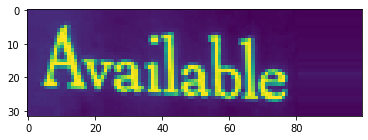

In [63]:
print(image_tensors.size())
plt.imshow(image_tensors[0][0])
print(preds.size())

In [64]:
#font training data from kaggle
!pip install kaggle

In [65]:
#make a folder to put authentication key
!mkdir ~/.kaggle


In [66]:
# go to kaggle user profile, create API token, 
#run this cell to upload kaggle.jason to Colab runtime

from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [67]:
# Check
!cd ~/.kaggle/ && ls

kaggle.json


In [68]:
!kaggle datasets list -s 'typefaces' #search

ref                                title                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/killen/bw-font-typefaces  Letters organized by typefaces   38MB  2020-01-18 14:20:12             68          5  0.8125           
datasets/lubaroli/notmnist         notMNIST dataset                  8MB  2017-08-22 13:12:24           1421         18  0.625            
datasets/ethanp0810/typefaces      Typefaces                       338KB  2021-02-21 11:57:35             14          0  0.125            


In [69]:
!kaggle datasets download -d 'killen/bw-font-typefaces' #download

 93% 35.0M/37.8M [00:00<00:00, 63.1MB/s]
100% 37.8M/37.8M [00:00<00:00, 56.2MB/s]


In [70]:
#!sudo apt-get install unzip
#!unzip bw-font-typefaces.zip -d data/


Streaming output truncated to the last 5000 lines.
  inflating: data/VINERITC/s_l.png   
  inflating: data/VINERITC/t_l.png   
  inflating: data/VINERITC/u_l.png   
  inflating: data/VINERITC/v_l.png   
  inflating: data/VINERITC/w_l.png   
  inflating: data/VINERITC/x_l.png   
  inflating: data/VINERITC/y_l.png   
  inflating: data/VINERITC/z_l.png   
  inflating: data/VIVALDII/A.png     
  inflating: data/VIVALDII/B.png     
  inflating: data/VIVALDII/C.png     
  inflating: data/VIVALDII/D.png     
  inflating: data/VIVALDII/E.png     
  inflating: data/VIVALDII/F.png     
  inflating: data/VIVALDII/G.png     
  inflating: data/VIVALDII/H.png     
  inflating: data/VIVALDII/I.png     
  inflating: data/VIVALDII/J.png     
  inflating: data/VIVALDII/K.png     
  inflating: data/VIVALDII/L.png     
  inflating: data/VIVALDII/M.png     
  inflating: data/VIVALDII/N.png     
  inflating: data/VIVALDII/O.png     
  inflating: data/VIVALDII/P.png     
  inflating: data/VIVALDII/Q.png     

In [71]:
# count total fonts (folders 152)
!ls ./data -l | grep -c ^d

152


In [72]:
# split into training and validation sets
!pip install split-folders


In [73]:
import splitfolders
#!rm -rf ./data2
!mkdir ./data2
input_folder='./data'
splitfolders.ratio(input_folder,output="./data2",
                   seed=42,ratio=(0.7,0.3),
                   group_prefix=None)

Copying files: 15340 files [00:03, 4852.62 files/s]


In [74]:
#check font data 
image = './data2/train/AGENCYR/A.png'
image = read_image(image)
image.shape #224 x 224 x 3
#SIZE=224

(224, 224, 3)

In [75]:
#more libraries for transfer learning, and evaluation
#follow:
#https://github.com/python-engineer/pytorchTutorial/blob/master/15_transfer_learning.py
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import copy
import glob
import cv2
import numpy as np
import time
from torch.utils.data import DataLoader

In [91]:
# calculate for data used to train 

mean =np.array([0.485, 0.456, 0.406]) #for resnet18
std=np.array([0.229, 0.224, 0.225])
# prepare data
data_transforms ={
    'train': transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean,std)                            
    ]),
    'val': transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean,std)                            
    ])
}

In [92]:
#import data
data_dir='data2'
sets=['train','val']
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x),
                                         data_transforms[x])
                  for x in ['train','val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],batch_size=4,
                                              shuffle=True,num_workers=0)
                  for x in ['train','val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

print(len(class_names))    


152


In [93]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [94]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

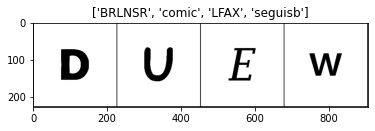

In [95]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [96]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [97]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
device

device(type='cuda')

In [99]:
criterion = nn.CrossEntropyLoss().to(device) 
optimizer = optim.SGD(model.parameters(), lr=0.001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=20)
PATH="font_model.pth"
torch.save(model.state_dict(), PATH)


Epoch 0/19
----------
train Loss: 2.3549 Acc: 0.4967
val Loss: 6.7042 Acc: 0.1169

Epoch 1/19
----------
train Loss: 2.2131 Acc: 0.5111
val Loss: 6.8669 Acc: 0.1234

Epoch 2/19
----------
train Loss: 2.0829 Acc: 0.5311
val Loss: 6.8312 Acc: 0.1208

Epoch 3/19
----------
train Loss: 1.9324 Acc: 0.5501
val Loss: 6.9688 Acc: 0.1274

Epoch 4/19
----------
train Loss: 1.8642 Acc: 0.5648
val Loss: 6.7023 Acc: 0.1227

Epoch 5/19
----------
train Loss: 1.7657 Acc: 0.5752
val Loss: 6.6345 Acc: 0.1255

Epoch 6/19
----------
train Loss: 1.6946 Acc: 0.5918
val Loss: 6.5387 Acc: 0.1306

Epoch 7/19
----------
train Loss: 1.5230 Acc: 0.6177
val Loss: 6.5457 Acc: 0.1285

Epoch 8/19
----------
train Loss: 1.4868 Acc: 0.6295
val Loss: 6.4676 Acc: 0.1302

Epoch 9/19
----------
train Loss: 1.4813 Acc: 0.6323
val Loss: 6.4941 Acc: 0.1257

Epoch 10/19
----------
train Loss: 1.4433 Acc: 0.6380
val Loss: 6.6600 Acc: 0.1294

Epoch 11/19
----------
train Loss: 1.4581 Acc: 0.6348
val Loss: 6.2691 Acc: 0.1311

Ep

In [86]:
# Try another model
rmodel = models.resnet18(pretrained=True)
num_ftrs = rmodel.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
rmodel.fc = nn.Linear(num_ftrs, 152)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [88]:
rmodel = model.to(device)
rmodel = train_model(rmodel, criterion, optimizer, step_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 3.9233 Acc: 0.3538
val Loss: 8.7124 Acc: 0.0848

Epoch 1/24
----------
train Loss: 2.9354 Acc: 0.4823
val Loss: 9.0856 Acc: 0.0994

Epoch 2/24
----------
train Loss: 2.4176 Acc: 0.5547
val Loss: 8.5389 Acc: 0.1169

Epoch 3/24
----------
train Loss: 2.0192 Acc: 0.6201
val Loss: 8.2082 Acc: 0.1176

Epoch 4/24
----------
train Loss: 1.8044 Acc: 0.6660
val Loss: 11.0353 Acc: 0.0780

Epoch 5/24
----------
train Loss: 0.6513 Acc: 0.8485
val Loss: 7.1743 Acc: 0.1396

Epoch 6/24
----------
train Loss: 0.6304 Acc: 0.8473
val Loss: 7.0447 Acc: 0.1403

Epoch 7/24
----------
train Loss: 0.5703 Acc: 0.8595
val Loss: 6.8791 Acc: 0.1461

Epoch 8/24
----------
train Loss: 0.5804 Acc: 0.8543
val Loss: 6.9171 Acc: 0.1373

Epoch 9/24
----------
train Loss: 0.5350 Acc: 0.8621
val Loss: 6.8842 Acc: 0.1390

Epoch 10/24
----------
train Loss: 0.5336 Acc: 0.8631
val Loss: 6.9567 Acc: 0.1454

Epoch 11/24
----------
train Loss: 0.5178 Acc: 0.8660
val Loss: 7.0872 Acc: 0.1435

E

In [89]:
#save model parameters
PATH="resnet_model_nonorm.pth"
torch.save(rmodel.state_dict(), PATH)
# model=Model(*args,**kwargs)
#model.load_state_dict(torch.load(PATH)
#model.eval()


In [98]:
# Try after normalization of training data
rmodel = model.to(device)
rmodel = train_model(rmodel, criterion, optimizer, step_lr_scheduler, num_epochs=10)
PATH="resnet_model_norm.pth"
torch.save(rmodel.state_dict(), PATH)

Epoch 0/9
----------
train Loss: 2.3702 Acc: 0.4971
val Loss: 6.7545 Acc: 0.1135

Epoch 1/9
----------
train Loss: 2.3274 Acc: 0.4982
val Loss: 7.0131 Acc: 0.1191

Epoch 2/9
----------
train Loss: 2.2789 Acc: 0.5004
val Loss: 6.7089 Acc: 0.1189

Epoch 3/9
----------
train Loss: 2.3011 Acc: 0.5053
val Loss: 6.7005 Acc: 0.1122

Epoch 4/9
----------
train Loss: 2.3252 Acc: 0.5000
val Loss: 6.8568 Acc: 0.1118

Epoch 5/9
----------
train Loss: 2.2541 Acc: 0.5048
val Loss: 7.0336 Acc: 0.1152

Epoch 6/9
----------
train Loss: 2.2690 Acc: 0.5069
val Loss: 6.6957 Acc: 0.1150

Epoch 7/9
----------
train Loss: 2.2613 Acc: 0.5089
val Loss: 6.8248 Acc: 0.1142

Epoch 8/9
----------
train Loss: 2.2906 Acc: 0.5015
val Loss: 6.8796 Acc: 0.1124

Epoch 9/9
----------
train Loss: 2.3064 Acc: 0.4939
val Loss: 6.7789 Acc: 0.1178

Training complete in 52m 33s
Best val Acc: 0.119083
